# Coherent dark states in a 3-level system
Investigating coherent dark states in 3-level system using the `toy_systems` package. 

The 3-level system will consist of two ground states which are both coupled to the same excited state, which in turn can decay back to both of the ground states. A similar situation can be found in TlF when driving optical transitions from the electronic ground state X to the excited state B. The spacing of hyperfine levels in X is much smaller than the natural linewidth of the transitions, so that multiple groundstate hyperfine states end up coupling to one excited state hyperfine state. The number of coherent dark states in this scenario is N-1 where N is the number of ground states coupling to the same excited state. The dark states are typically not eigenstates of the internal Hamiltonian (e.g. TlF internal Hamiltonian) and so they evolve into bright states over time - we'll investigate the rate at which this occurs as the coupling strength of the ground states to the excited state and their energy splitting is varied.
## Imports
Start by importing the necessary packages

In [47]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import scipy
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.dark_states import get_dark_states
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up states and basis
We start by defining the three states of the system: the ground states $|g0\rangle$ and $|g1\rangle$, and the excited state $|e\rangle$>

In [2]:
g0 = BasisState(qn=ToyQuantumNumbers(label="g0"))
g1 = BasisState(qn=ToyQuantumNumbers(label="g1"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Define basis
basis = Basis((g0,g1,e))
basis.print_basis()

|0> = |g0>
|1> = |g1>
|2> = |e>


## Define energies, couplings, decays and quantum system
I'm going to define the system in the rotating frame as usual.

### Energies

In [3]:
δ = Symbol('delta') # Energy splitting between |g0> and |g1
Δ = Symbol('Delta') # Detuning of drive field from 0
E0 = ToyEnergy(g0, -δ/2)
E1 = ToyEnergy(g1, +δ/2)
Ee = ToyEnergy(e, Δ)

### Couplings

In [4]:
Ω0 = Symbol('Omega_0') # Drive field Rabi rate for |g0> <-> |e>
Ω1 = Symbol('Omega_1') # Drive field Rabi rate for |g1> <-> |e>

coupling_0 = ToyCoupling(g0,e,Ω0)
coupling_1 = ToyCoupling(g1,e,Ω1)

### Decays
Defining a decay from $|e\rangle$ to $|g0\rangle$ and $|g1\rangle$:

In [5]:
decay_0 = ToyDecay(e, ground = g0, gamma = Symbol("Gamma_0"))
decay_1 = ToyDecay(e, ground = g1, gamma = Symbol("Gamma_1"))

### Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

In [6]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E0, E1, Ee, coupling_0, coupling_1],
    decays=[decay_0, decay_1],
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Find dark states
There is some rudimentary functionality in `toy_systems` for finding the bright and dark states when a number of ground states are coupled to a single excited state. Let's test that here:

In [7]:
bright_state, dark_states = get_dark_states([g0, g1], e, [coupling_0, coupling_1])

print(f"|B> =\n{bright_state}")

print(f"\n|D> =\n{dark_states[0]}")

print(f"\n<B|D> = {dark_states[0]@bright_state}")

|B> =
0.71+0.00j x |g0>
0.71+0.00j x |g1>

|D> =
0.71+0.00j x |g0>
-0.71+0.00j x |g1>

<B|D> = 0j


## Time evolution
No matter what state, the system starts in, it should always end up in the dark state, from which it will slowly decay out since the dark state is not an eigenstate of the Hamiltonian.

In [8]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'delta': 1, 'Delta': 1, 'Omega_0': 1, 'Omega_1': 1, 'Gamma_0': 1, 'Gamma_1': 1}


In [13]:
dark_states

[1.00+0.00j x |g0>
 -0.10+0.00j x |g1>]

In [14]:
bright_state

1.00+0.00j x |g1>
0.10+0.00j x |g0>

In [45]:
# Generate a Qobj representing the initial state
psi0 = (1*g0).qobj(basis)

# Set the parameters for the system
args['delta'] = 0.01
args['Delta'] = 0
args['Omega_0'] = 0.5
args['Omega_1'] = 0.5
args['Gamma_0'] = 1/2
args['Gamma_1'] = 1/2
Gamma = args['Gamma_0'] + args['Gamma_1']

# Get different dark and bright states for different values of Omegas so recalculate them
coupling_0.mag = args["Omega_0"]
coupling_1.mag = args["Omega_1"]
bright_state, dark_states = get_dark_states([g0, g1], e, [coupling_0, coupling_1])

# Operators for getting probability of being in each state as a function of time
P_g0 = qutip.Qobj((1*g0).density_matrix(basis), type = "oper")
P_g1 = qutip.Qobj((1*g1).density_matrix(basis), type = "oper")
P_e = qutip.Qobj((1*e).density_matrix(basis), type = "oper")
P_B = qutip.Qobj(bright_state.density_matrix(basis), type = "oper")
P_D = qutip.Qobj(dark_states[0].density_matrix(basis), type = "oper")
P_ops = [P_g0, P_g1, P_e, P_B, P_D]

# Times at which result is requested
times = np.linspace(0,100*Gamma,1001)

# Setting the max_step is sometimes necessary
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = P_ops,
                      progress_bar=pb, options = options)

 Total run time:   0.51s*] Elapsed 0.51s / Remaining 00:00:00:00[*********56%*          ] Elapsed 0.26s / Remaining 00:00:00:00


|B> =
0.71+0.00j x |g0>
0.71+0.00j x |g1>

|D> =
0.71+0.00j x |g0>
-0.71+0.00j x |g1>

Population in excited state at the end: 1.0e-02 %
Photons emitted on average: 2.009238706416741


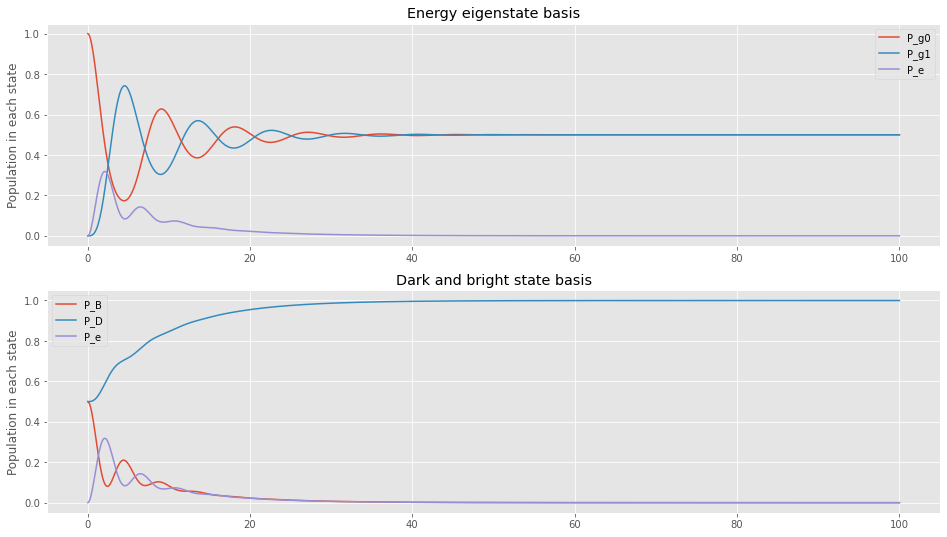

In [46]:
fig, ax = plt.subplots(2, 1, figsize = (16,9))
ax[0].plot(times, result.expect[0], label = "P_g0")
ax[0].plot(times, result.expect[1], label = "P_g1")
ax[0].plot(times, result.expect[2], label = "P_e")
ax[0].legend()
ax[0].set_ylabel("Population in each state")
ax[0].set_title("Energy eigenstate basis")

ax[1].plot(times, result.expect[3], label = "P_B")
ax[1].plot(times, result.expect[4], label = "P_D")
ax[1].plot(times, result.expect[2], label = "P_e")
ax[1].legend()
ax[1].set_ylabel("Population in each state")
ax[1].set_title("Dark and bright state basis")


print(f"|B> =\n{bright_state}")

print(f"\n|D> =\n{dark_states[0]}")

print(f"\nPopulation in excited state at the end: {result.expect[2][-1]*100:.1e} %")
print(f"Photons emitted on average: {scipy.integrate.trapezoid(result.expect[2], x = times)}")